# Setup
I have moved the new data into my `Data` folder and I am tracking it using DVC.
I already have the pipeline code for fetching the data from DVC, Cleaning the CSV, and 
Training a different models. 

Now, I am importing them and some other libraries I need.

In [1]:
# Importing Pandas an Numpy Libraries to use on manipulating our Data
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import cross_val_score

import sys
sys.path.append("../")

from Scripts.modeling_pipeline import (
    run_train_pipeline, 
    get_pipeline,
    dvc_get_data)
from Scripts.cleaning import CleanDataFrame
from Scripts.exploration import Analysis
from Scripts.visualization import Plotters
from sklearn.utils import shuffle

import os
import mlflow

# Getting the data

Here, I am using the dvc wrapper I wrote to fetch data being tracked with DVC using it's path and git Tag or commit hash

In [2]:
df = dvc_get_data(path="Data/ABtwoCampaignEngView.csv", version="v6")

I'm curious about what will be different with this data from the other one I was working with.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912712 entries, 0 to 912711
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   912712 non-null  int64  
 1   auction_id   912712 non-null  object 
 2   experiment   912712 non-null  object 
 3   date         912712 non-null  object 
 4   hour         912712 non-null  int64  
 5   device_make  912712 non-null  object 
 6   platform_os  912712 non-null  int64  
 7   browser      912712 non-null  int64  
 8   yes          912712 non-null  float64
 9   no           912712 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 69.6+ MB


# Cleaning

It doesn't look like there are any missing entries. But let's confirm this.

In [4]:
cleaner = CleanDataFrame()
cleaner.percent_missing(df)

The dataset contains 0.0 % missing values.


Next, let's see if there are duplicated rows using the auction_id

In [5]:
display(df[df.duplicated('auction_id', False)].head())
print("Duplicated rows:", df[df.duplicated('auction_id', False)].shape[0])

,Unnamed: 0,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
153,611695,415c4ac6-cc80-4f84-856c-9e821ba37fa7,control,<built-in method date of Timestamp object at 0...,19,Apple,101,7,0.0,0.0
180,105739,0b4b114a-7be3-435e-beb5-76cbd29ae329,control,<built-in method date of Timestamp object at 0...,8,Apple,101,15,0.0,1.0
336,1752177,bb84fd6a-7353-4157-9f84-e30159e38b8e,control,<built-in method date of Timestamp object at 0...,6,Apple,101,15,0.0,0.0
509,460884,3144fd93-dc96-424c-8ba8-6f24078d3c09,control,<built-in method date of Timestamp object at 0...,22,Apple,171,7,0.0,0.0
566,303927,20715f98-69b8-41aa-ae78-5ab1b65682a2,control,<built-in method date of Timestamp object at 0...,20,Apple,101,7,0.0,0.0


Duplicated rows: 39358


There are indeed duplicated rows. There is also a problem with the date column. 
It looks like they forgot to call a string to datetime format converter method.
Now, we just have the method signature as a string

In the next step I will remove the columns I won't need. I will also remove users that didn't reponde

1. Unnamed: 0   (this is just an index column)
2. auction_id   (this helps to differentiate users, won't help for our task. )
3. date         (doesn't represent the date, it's just a method signature)
4. no           (I can just use the Yes column and treat it as a binary classifier)

In [6]:
clean_df = cleaner.drop_duplicates(df)
clean_df = cleaner.drop_unresponsive(clean_df)
clean_df = cleaner.drop_columns(df=clean_df,
                columns=['Unnamed: 0', 'auction_id', 'date', 'no'])
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96617 entries, 80 to 912706
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   experiment   96617 non-null  object 
 1   hour         96617 non-null  int64  
 2   device_make  96617 non-null  object 
 3   platform_os  96617 non-null  int64  
 4   browser      96617 non-null  int64  
 5   yes          96617 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 5.2+ MB


Let's look at the unique entries for the device_make, platform_os and browser column.
This helps me choose how to encode them for my models.

In [7]:
unique_device_make = clean_df.device_make.unique().shape
unique_browsers = clean_df.browser.unique().shape
unique_os = clean_df.platform_os.unique().shape

print(f"unique_device_make: {unique_device_make[0]}")
print(f"unique_browsers: {unique_browsers[0]}")
print(f"unique_os: {unique_os[0]}")

unique_device_make: 89
unique_browsers: 7
unique_os: 44


# EDA

In [7]:
analyzer = Analysis()

I have a function that will help me do a Univariate analysis on the numerical columns of my data.

In [8]:
analyzer.get_univariate_analysis(clean_df)

,count,mean,std,min,25%,50%,75%,max,mode,CoV,skew,kurtosis,iqr,missing_counts
hour,96617.0,10.063571,7.387838,0.0,3.0,10.0,17.0,23.0,2.0,0.734117,0.178519,-1.415354,14.0,0
platform_os,96617.0,117.050964,27.770550,101.0,101.0,101.0,145.0,180.0,101.0,0.237252,1.219523,-0.359402,44.0,0
browser,96617.0,7.930250,3.549317,1.0,6.0,6.0,7.0,15.0,6.0,0.447567,1.467704,0.205009,1.0,0
yes,96617.0,0.875560,0.330084,0.0,1.0,1.0,1.0,1.0,1.0,0.376998,-2.275588,3.178367,0.0,0


`platform_os` and `browser` were supposed to be strings, They must have been pre encoded in to numbers.

Next, I will explore the categorical columns in the data.
I will plot the 10 most common values in each columns

In [9]:
plotters = Plotters(w=6, h=4)

6     64421
15    19293
7     12770
5        79
12       34
1        11
8         9
Name: browser, dtype: int64

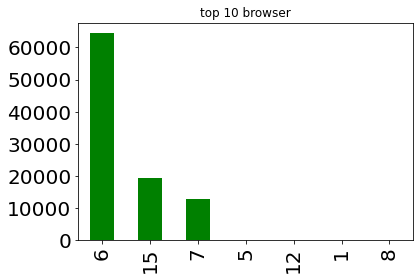

In [10]:
plotters.plot_top_n_counts(clean_df, 'browser', top_n=10, title="top 10 browser")


101    71855
162     8605
156     4232
178     3508
155     3180
179     1135
174      783
175      646
173      374
171      374
Name: platform_os, dtype: int64

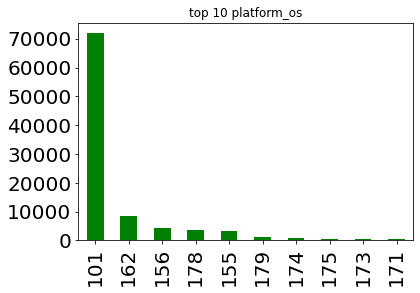

In [11]:
plotters.plot_top_n_counts(clean_df, 'platform_os', top_n=10, title="top 10 platform_os")


Samsung     46525
Apple       23065
Google      20908
Motorola     2285
LG           1619
OnePlus       684
Amazon        287
TCL           274
HTC            90
Xiaomi         69
Name: device_make, dtype: int64

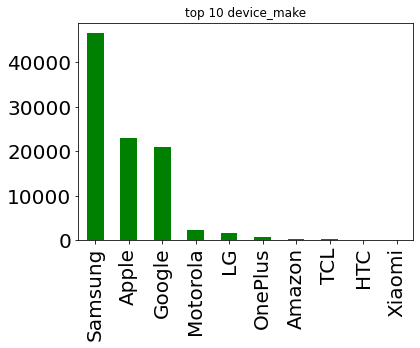

In [12]:
plotters.plot_top_n_counts(clean_df, 'device_make', top_n=10, title="top 10 device_make")

I want to know the number of users in the `exposed` and `control` groups. A Pie chart should help me here.

In [13]:
clean_df.experiment.value_counts()

exposed    78973
control    17644
Name: experiment, dtype: int64

<AxesSubplot:ylabel='experiment'>

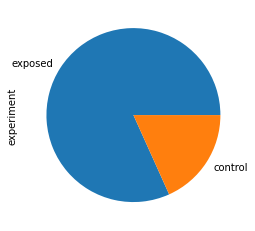

In [14]:
clean_df.experiment.value_counts().plot.pie()

This might create a problem for the modeling.

In [15]:
clean_df.experiment.value_counts().values[0] / clean_df.experiment.value_counts().values[1]

4.475912491498526

This might cause problems. We have almost 5 times as much samples for exposed users as we have from control group.
I will need to resample the data to have equal number of `exposed` and `controll` users.

# Modeling with cleaned raw data

## Create X and Y
The features are the following columns:

 * `experiment`
 * `hour`
 * `device_make`
 * `platform_os`
 * `browser`

The label will be the `yes` column

In [17]:
x = clean_df.drop(columns=['yes'])
y = clean_df['yes'].values


To train a model, All I have to do is utilize my previous code. It takes the model I want to train, input features, the label, and parameters related to mlflow logging.
This then plugges the model we give it, into a predefiend pipeline that uses sklearn.pipelines.
It trains the model and logs the following:

    * metrics
    * feature importance
    * plots

## Train

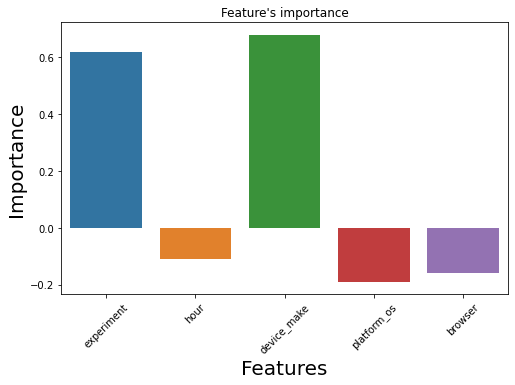

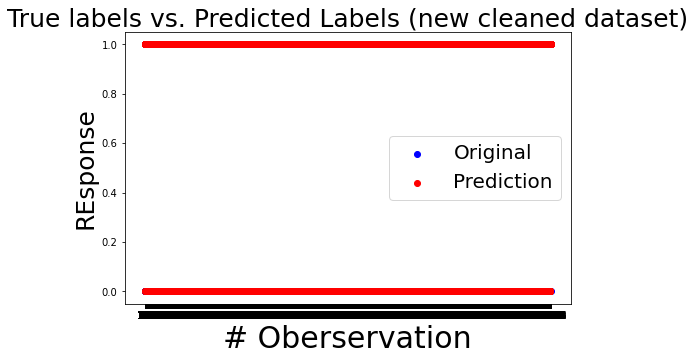

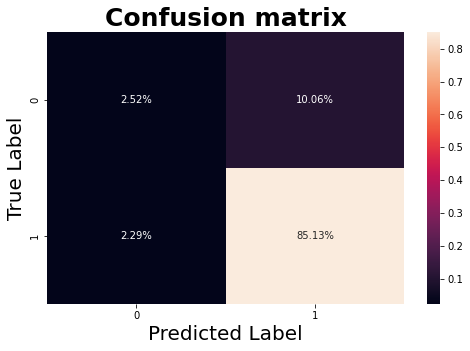

{'accuracy': 0.88, 'precision': 0.89, 'recall': 0.97, 'entropy': 0.29, 'true_pos': 730, 'true_neg': 24676, 'false_pos': 2916, 'false_neg': 664}
{'experiment': 0.62, 'hour': -0.11, 'device_make': 0.68, 'platform_os': -0.19, 'browser': -0.16}
Saving figures


Successfully registered model 'new cleaned dataset_Logistic Regression on unbalanced data_Mon-May-23-17:05:46-2022'.
2022/05/23 17:06:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: new cleaned dataset_Logistic Regression on unbalanced data_Mon-May-23-17:05:46-2022, version 1
Created version '1' of model 'new cleaned dataset_Logistic Regression on unbalanced data_Mon-May-23-17:05:46-2022'.


Run - Logistic Regression on unbalanced data is logged to Experiment - new cleaned dataset


In [18]:
mlflow.end_run()
model = LogisticRegression()
run_train_pipeline(model, x, y, 
                experiment_name='new cleaned dataset',
                run_name='Logistic Regression on unbalanced data')

mlflow.end_run()

The model seems to be doing good, but the data is not balanced. It has a lot 1's (yes) compared to 0's (no)

I will try balancing it.

# Modeling after balancing with experiment

Now, I am using the balanced verison of my dataset and creating the features and labels.

In [7]:
exposed = clean_df[clean_df['experiment']=='exposed'].reset_index(drop=True)
exposed = shuffle(exposed).reset_index(drop=True)
control = clean_df[clean_df['experiment']=='control'].reset_index(drop=True)
balanced_by_experiment = control.append(exposed.loc[:len(control), :])

balanced_by_experiment = shuffle(balanced_by_experiment).reset_index(drop=True)



/tmp/ipykernel_34096/1201888155.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = control.append(exposed.loc[:len(control), :])


In [8]:
x = balanced_by_experiment.drop(columns=['yes'])
y = balanced_by_experiment['yes'].values


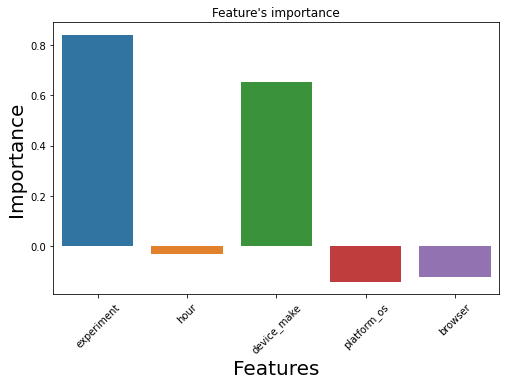

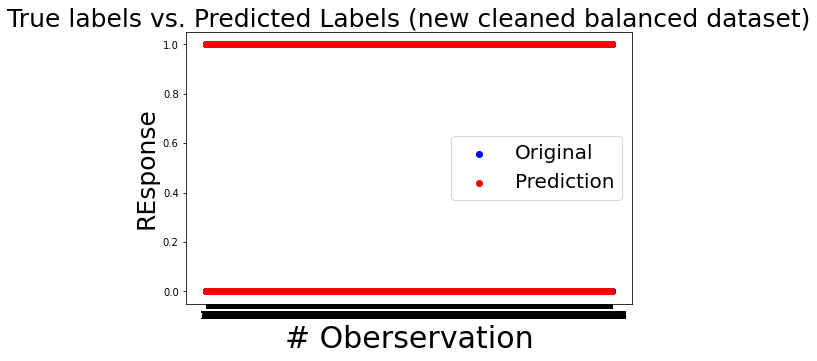

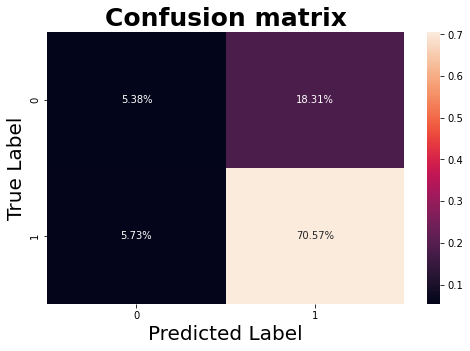

{'accuracy': 0.76, 'precision': 0.79, 'recall': 0.92, 'entropy': 0.44, 'true_pos': 570, 'true_neg': 7471, 'false_pos': 1939, 'false_neg': 607}
{'experiment': 0.84, 'hour': -0.03, 'device_make': 0.65, 'platform_os': -0.14, 'browser': -0.12}


2022/05/23 17:37:49 INFO mlflow.tracking.fluent: Experiment with name 'new cleaned balanced dataset' does not exist. Creating a new experiment.


Saving figures


Successfully registered model 'new cleaned balanced dataset_logistic regression_Mon-May-23-17:39:27-2022'.
2022/05/23 17:39:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: new cleaned balanced dataset_logistic regression_Mon-May-23-17:39:27-2022, version 1
Created version '1' of model 'new cleaned balanced dataset_logistic regression_Mon-May-23-17:39:27-2022'.


Run - logistic regression is logged to Experiment - new cleaned balanced dataset


In [9]:
model = LogisticRegression()
run_train_pipeline(model, x, y, 
                experiment_name='new cleaned balanced dataset',
                run_name='logistic regression')

mlflow.end_run()

Maybe the data is not balanced regarding the responses

In [10]:
balanced_by_experiment.yes.value_counts()

1.0    26923
0.0     8366
Name: yes, dtype: int64

Yup, there are way more No's than Yes's, That explaines why we have good result in the 4th quadrant in the confussion matrix.
I'm going to change the model to XGBoost Classifer based on Random Forest just for sanity check.

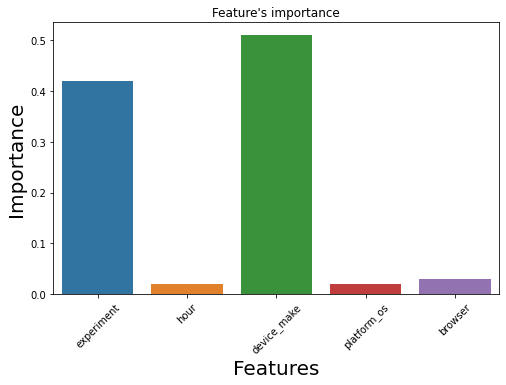

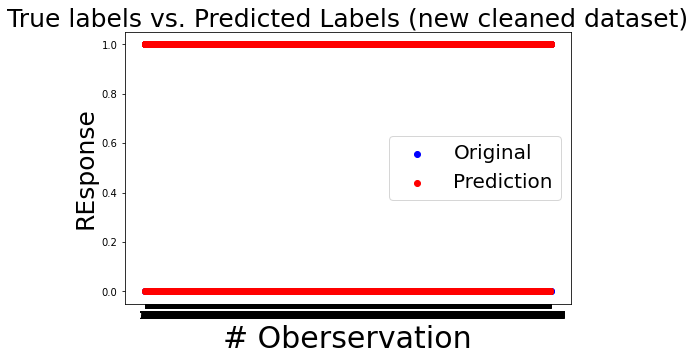

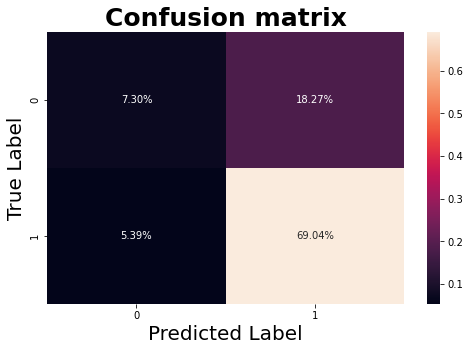

{'accuracy': 0.76, 'precision': 0.79, 'recall': 0.93, 'entropy': 0.48, 'true_pos': 773, 'true_neg': 7309, 'false_pos': 1934, 'false_neg': 571}
{'experiment': 0.42, 'hour': 0.02, 'device_make': 0.51, 'platform_os': 0.02, 'browser': 0.03}
Saving figures


Successfully registered model 'new cleaned dataset_XGBRFClassifier_Sun-May-22-16:48:50-2022'.
2022/05/22 16:49:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: new cleaned dataset_XGBRFClassifier_Sun-May-22-16:48:50-2022, version 1
Created version '1' of model 'new cleaned dataset_XGBRFClassifier_Sun-May-22-16:48:50-2022'.


Run - XGBRFClassifier is logged to Experiment - new cleaned dataset


In [23]:
mlflow.end_run()
model = XGBRFClassifier()
run_train_pipeline(model, x, y, 
                experiment_name='new cleaned dataset',
                run_name='XGBRFClassifier')

mlflow.end_run()

In both the above models, we can see that the `experiment` column has a high positive correlation with the tagrget value.
But in both cases, the `device_make` has the highest importance. 



# Modeling after balancing with response
Time to deal with the unbalanced labels. For now I will just take a sample size of yes responses that is equal to no's

In [16]:
clean_df.yes.value_counts()

1.0    84594
0.0    12023
Name: yes, dtype: int64

In [17]:
aware = clean_df.query("yes==1").reset_index(drop=True)
aware = shuffle(aware).reset_index(drop=True)
not_aware = clean_df.query("yes==0").reset_index(drop=True)
aware = aware.loc[:not_aware.shape[0], :].copy()
balanced_by_response = pd.concat([aware, not_aware])
balanced_by_response = shuffle(balanced_by_response).reset_index(drop=True)
display(balanced_by_response.info())

x = balanced_by_response.drop(columns=['yes'])
y = balanced_by_response['yes'].values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24047 entries, 0 to 24046
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   experiment   24047 non-null  object 
 1   hour         24047 non-null  int64  
 2   device_make  24047 non-null  object 
 3   platform_os  24047 non-null  int64  
 4   browser      24047 non-null  int64  
 5   yes          24047 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


None

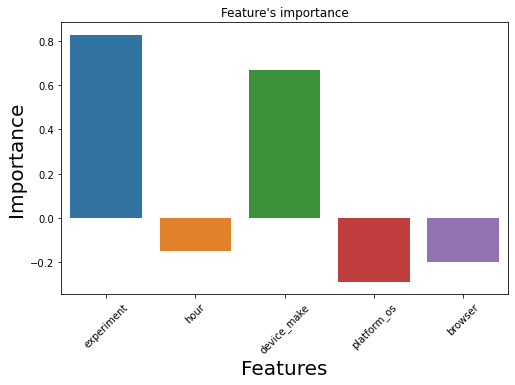

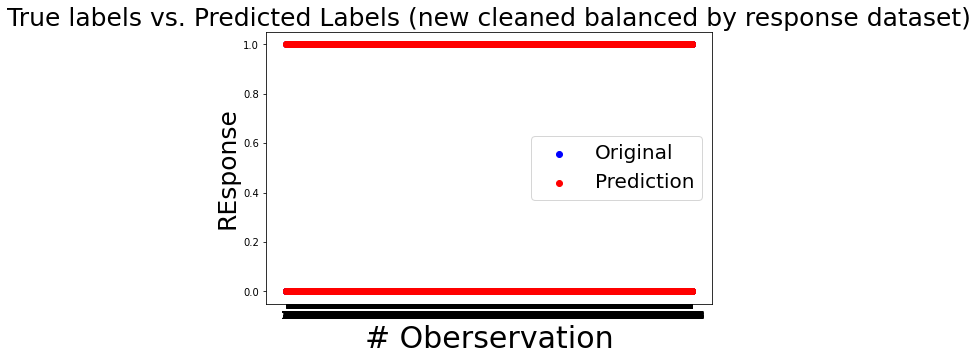

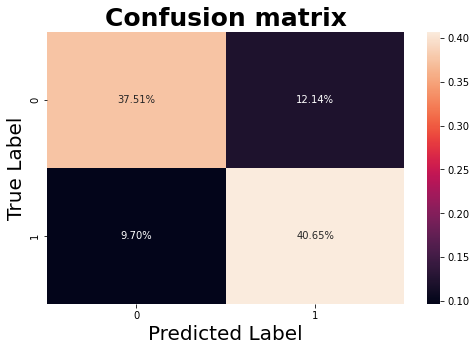

{'accuracy': 0.78, 'precision': 0.77, 'recall': 0.81, 'entropy': 0.51, 'true_pos': 2706, 'true_neg': 2933, 'false_pos': 876, 'false_neg': 700}
{'experiment': 0.83, 'hour': -0.15, 'device_make': 0.67, 'platform_os': -0.29, 'browser': -0.2}


2022/05/23 18:03:24 INFO mlflow.tracking.fluent: Experiment with name 'new cleaned balanced by response dataset' does not exist. Creating a new experiment.


Run params saved
Run metrics saved
logging figures
figures saved with mlflow
figures saved
Saving artifacts
saving dict


Successfully registered model 'new cleaned balanced by response dataset_logistic regression_Mon-May-23-18:04:24-2022'.
2022/05/23 18:04:32 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: new cleaned balanced by response dataset_logistic regression_Mon-May-23-18:04:24-2022, version 1
Created version '1' of model 'new cleaned balanced by response dataset_logistic regression_Mon-May-23-18:04:24-2022'.


Run - logistic regression is logged to Experiment - new cleaned balanced by response dataset


In [19]:
model = LogisticRegression()
run_train_pipeline(model, x, y, 
                experiment_name='new cleaned balanced by response dataset',
                run_name='logistic regression')

mlflow.end_run()

The Feature Importance bar plot shows that the experiment column has a lot of contributions to the model. So, There is a change in the customers brand awareness that is dependent on the experiment group they were in.
